# In this notebook we classify comments from Reddit as sarcastic or nonsarcastic

### Mount to data source in Colab

In [1]:
if not ('drive' in locals() or 'drive' in globals()):
  from google.colab import drive
  drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Import packages

In [0]:
import numpy as np
import pandas as pd
import random
import string

from sklearn import preprocessing
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split, KFold
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer

import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline
# %config InlineBackend.figure_format = 'retina'

### Settings

In [0]:
# display entire text of comment strings in dataframe output
pd.set_option('display.max_colwidth', -1)

#### Create function to read in a random sample of the data

In [0]:
# p is set to a value between 0.0 and 1.0, so we an read in a percentage `p` sized portion of the data
p = 1.0

def read_in_data(file):
    return pd.read_csv(file, 
                       sep='\t', 
                       header=None, 
                       names=['label','comment','author','subreddit','score',
                              'ups','downs','date','created_utc','parent_comment'],
                       usecols=['label','author','subreddit','score',
                              'date','created_utc','parent_comment','comment'],  # ignore ups and downs cols
                       skiprows=lambda i: i>0 and random.random() > p)

Read in a `p`-sized random sample of the data from **data_train**

In [0]:
# # if running on local machine:
# data_train = read_in_data("../data/train-balanced.csv")

# if running on colab with data on google drive:
data_train = read_in_data("/content/drive/My Drive/capstone_repo/data/train-balanced.csv")

#### Reorder columns

In [7]:
data_train = data_train[['label', 'author', 'subreddit', 'score', 'parent_comment', 'comment']]

data_train.head()

,label,author,subreddit,score,parent_comment,comment
0,0,Trumpbart,politics,2,"Yeah, I get that argument. At this point, I'd prefer is she lived in NC as well.",NC and NH.
1,0,Shbshb906,nba,-4,The blazers and Mavericks (The wests 5 and 6 seed) did not even carry a good enough record to make the playoffs in the east last year.,You do know west teams play against west teams more than east teams right?
2,0,Creepeth,nfl,3,They're favored to win.,"They were underdogs earlier today, but since Gronk's announcement this afternoon, the Vegas line has moved to patriots -1"
3,0,icebrotha,BlackPeopleTwitter,-8,deadass don't kill my buzz,"This meme isn't funny none of the ""new york nigga"" ones are."
4,0,cush2push,MaddenUltimateTeam,6,Yep can confirm I saw the tool they use for that. It was made by our boy EASports_MUT,I could use one of those tools.


#### Create function to find NA values, if any, in data

In [0]:
def identify_NA_values_in_data(df):
    # Any NAs?
    print('NAs exist in this sample (T/F):', df.isnull().values.any(), '\n')
    # How many?
    print('How many NAs in this sample?', df.isnull().sum().sum(), '\n')  # 53 in entire TRAIN dataset
    # In which columns?
    print('Which cols have NAs in this sample?\n')
    print(df.isnull().any(), '\n')

    # How many of them are sarcasm?
    print('Of these NAs, how many are labeled sarcasm?\n')
    nulls = df[df['comment'].isnull()]  
    nulls_sarc = nulls[nulls['label'] == 1]
    print('\tNumber of null comments in sample that are sarcasm:',len(nulls_sarc))
    if not len(nulls) == 0:
        print('\tRatio of sarcastic null comments to all null comments in sample:', len(nulls_sarc) / len(nulls))
    else:
        print('\tRatio of sarcastic null comments to all null comments in sample: 0 of 0')
        

Run identify_NA_values_in_data on **data_train**

In [9]:
identify_NA_values_in_data(data_train)

NAs exist in this sample (T/F): True 

How many NAs in this sample? 53 

Which cols have NAs in this sample?

label             False
author            False
subreddit         False
score             False
parent_comment    False
comment           True 
dtype: bool 

Of these NAs, how many are labeled sarcasm?

	Number of null comments in sample that are sarcasm: 45
	Ratio of sarcastic null comments to all null comments in sample: 0.8490566037735849


Read in a random sample of the data from **data_test**

In [10]:
# # if running on local machine:
# data_test = read_in_data("../data/test-balanced.csv")

# if running on colab with data on google drive:
data_test = read_in_data("/content/drive/My Drive/capstone_repo/data/test-balanced.csv")

data_test = data_test[['label', 'author', 'subreddit', 'score', 'parent_comment', 'comment']]

print(data_test.shape, '\n')
data_test.head()

(251608, 6) 



,label,author,subreddit,score,parent_comment,comment
0,0,Quinnjester,politics,3,Hillary's Surrogotes Told to Blame Media for 'Deplorables' Coverage,Actually most of her supporters and sane people saw what the Media was doing....especially the AP tweet.
1,0,TheGettysburgAddress,The_Donald,13,Thank God Liberals like to live in concentrated little pockets instead of spreading out.,They can't survive without an echo chamber which is great for America.
2,0,Sempiternally_free,2007scape,8,Saw this cutie training his Attack today...,you're pretty cute yourself 1729 total
3,0,Catacomb82,AskReddit,2,"If you were locked in a room with 49 other people, and after 1 hour, the group would vote for 1 person to be executed, how would you convince the group not to execute you, and what would you base your vote on?",If you kill me you'll crash the meme market
4,0,Dorian-throwaway,niceguys,5,You're not even that pretty!,I bet he wrote that last message as he was sobbing.


#### Create function to view data types, number of non-null rows per col, and memory usage

In [0]:
def view_df_info(df):
    return df.info(memory_usage='deep', null_counts=True)

In [12]:
#data_TRAIN
view_df_info(data_train)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1010826 entries, 0 to 1010825
Data columns (total 6 columns):
label             1010826 non-null int64
author            1010826 non-null object
subreddit         1010826 non-null object
score             1010826 non-null int64
parent_comment    1010826 non-null object
comment           1010773 non-null object
dtypes: int64(2), object(4)
memory usage: 437.7 MB


In [13]:
# data_TEST
view_df_info(data_test)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 251608 entries, 0 to 251607
Data columns (total 6 columns):
label             251608 non-null int64
author            251608 non-null object
subreddit         251608 non-null object
score             251608 non-null int64
parent_comment    251608 non-null object
comment           251594 non-null object
dtypes: int64(2), object(4)
memory usage: 108.9 MB


In [14]:
# data_TRAIN
data_train.describe()

,label,score
count,1010826.0,1.010826e+06
mean,0.5,6.885676e+00
std,0.5,4.834288e+01
min,0.0,-5.070000e+02
25%,0.0,1.000000e+00
50%,0.5,2.000000e+00
75%,1.0,4.000000e+00
max,1.0,9.070000e+03


In [15]:
# data_TEST
data_test.describe()

,label,score
count,251608.000000,251608.000000
mean,0.500000,6.757452
std,0.500001,48.450781
min,0.000000,-329.000000
25%,0.000000,1.000000
50%,0.500000,2.000000
75%,1.000000,4.000000
max,1.000000,9923.000000


In [16]:
# data_TEST
identify_NA_values_in_data(data_test)

NAs exist in this sample (T/F): True 

How many NAs in this sample? 14 

Which cols have NAs in this sample?

label             False
author            False
subreddit         False
score             False
parent_comment    False
comment           True 
dtype: bool 

Of these NAs, how many are labeled sarcasm?

	Number of null comments in sample that are sarcasm: 9
	Ratio of sarcastic null comments to all null comments in sample: 0.6428571428571429


#### Drop NAs

In [0]:
data_train.dropna(inplace=True)
data_test.dropna(inplace=True)

## Preprocessing

### 1. Lowercase words and remove stopwords

#### Load stopwords from NLTK

In [0]:
try:
  sw = stopwords.words('english') # works 80% of time but sometimes throws LookupError
except LookupError:
  import nltk
  nltk.download('stopwords')  
  sw = stopwords.words('english')

# view stop words
np.array(sw)

#### Create function to remove stopwords

In [0]:
def remove_stopwords_and_lowercase(comment):
    '''This function lowercases words and then removes stopwords.'''
    
    comment = [word.lower() for word in comment.split() if word.lower() not in sw]
    return ' '.join(comment)

#### Apply the remove_stopwords_and_lowercase function to each comment


In [20]:
# data_TRAIN
data_train['comment_lc_stopped'] = data_train['comment'].apply(remove_stopwords_and_lowercase)

data_train.head()

,label,author,subreddit,score,parent_comment,comment,comment_lc_stopped
0,0,Trumpbart,politics,2,"Yeah, I get that argument. At this point, I'd prefer is she lived in NC as well.",NC and NH.,nc nh.
1,0,Shbshb906,nba,-4,The blazers and Mavericks (The wests 5 and 6 seed) did not even carry a good enough record to make the playoffs in the east last year.,You do know west teams play against west teams more than east teams right?,know west teams play west teams east teams right?
2,0,Creepeth,nfl,3,They're favored to win.,"They were underdogs earlier today, but since Gronk's announcement this afternoon, the Vegas line has moved to patriots -1","underdogs earlier today, since gronk's announcement afternoon, vegas line moved patriots -1"
3,0,icebrotha,BlackPeopleTwitter,-8,deadass don't kill my buzz,"This meme isn't funny none of the ""new york nigga"" ones are.","meme funny none ""new york nigga"" ones are."
4,0,cush2push,MaddenUltimateTeam,6,Yep can confirm I saw the tool they use for that. It was made by our boy EASports_MUT,I could use one of those tools.,could use one tools.


In [21]:
# data_TEST
data_test['comment_lc_stopped'] = data_test['comment'].apply(remove_stopwords_and_lowercase)

data_test.head()

,label,author,subreddit,score,parent_comment,comment,comment_lc_stopped
0,0,Quinnjester,politics,3,Hillary's Surrogotes Told to Blame Media for 'Deplorables' Coverage,Actually most of her supporters and sane people saw what the Media was doing....especially the AP tweet.,actually supporters sane people saw media doing....especially ap tweet.
1,0,TheGettysburgAddress,The_Donald,13,Thank God Liberals like to live in concentrated little pockets instead of spreading out.,They can't survive without an echo chamber which is great for America.,can't survive without echo chamber great america.
2,0,Sempiternally_free,2007scape,8,Saw this cutie training his Attack today...,you're pretty cute yourself 1729 total,pretty cute 1729 total
3,0,Catacomb82,AskReddit,2,"If you were locked in a room with 49 other people, and after 1 hour, the group would vote for 1 person to be executed, how would you convince the group not to execute you, and what would you base your vote on?",If you kill me you'll crash the meme market,kill crash meme market
4,0,Dorian-throwaway,niceguys,5,You're not even that pretty!,I bet he wrote that last message as he was sobbing.,bet wrote last message sobbing.


### 2. Remove punctuation
#### Create function to remove punctuation

In [0]:
def remove_punc(comment):
    '''This function uses str methods from the string class to remove punctuation from the text.'''
    
    
    # replace punctuation with '' (no space)
    translator = str.maketrans('', '', string.punctuation)
    
    # return the text stripped of punctuation marks
    return comment.translate(translator)

#### Apply remove_punc function to each TRAIN and TEST comment

In [23]:
# data_TRAIN
data_train['comment_depunced'] = data_train['comment_lc_stopped'].apply(remove_punc)

data_train.head()

,label,author,subreddit,score,parent_comment,comment,comment_lc_stopped,comment_depunced
0,0,Trumpbart,politics,2,"Yeah, I get that argument. At this point, I'd prefer is she lived in NC as well.",NC and NH.,nc nh.,nc nh
1,0,Shbshb906,nba,-4,The blazers and Mavericks (The wests 5 and 6 seed) did not even carry a good enough record to make the playoffs in the east last year.,You do know west teams play against west teams more than east teams right?,know west teams play west teams east teams right?,know west teams play west teams east teams right
2,0,Creepeth,nfl,3,They're favored to win.,"They were underdogs earlier today, but since Gronk's announcement this afternoon, the Vegas line has moved to patriots -1","underdogs earlier today, since gronk's announcement afternoon, vegas line moved patriots -1",underdogs earlier today since gronks announcement afternoon vegas line moved patriots 1
3,0,icebrotha,BlackPeopleTwitter,-8,deadass don't kill my buzz,"This meme isn't funny none of the ""new york nigga"" ones are.","meme funny none ""new york nigga"" ones are.",meme funny none new york nigga ones are
4,0,cush2push,MaddenUltimateTeam,6,Yep can confirm I saw the tool they use for that. It was made by our boy EASports_MUT,I could use one of those tools.,could use one tools.,could use one tools


In [24]:
# data_TEST
data_test['comment_depunced'] = data_test['comment_lc_stopped'].apply(remove_punc)


data_test.head()

,label,author,subreddit,score,parent_comment,comment,comment_lc_stopped,comment_depunced
0,0,Quinnjester,politics,3,Hillary's Surrogotes Told to Blame Media for 'Deplorables' Coverage,Actually most of her supporters and sane people saw what the Media was doing....especially the AP tweet.,actually supporters sane people saw media doing....especially ap tweet.,actually supporters sane people saw media doingespecially ap tweet
1,0,TheGettysburgAddress,The_Donald,13,Thank God Liberals like to live in concentrated little pockets instead of spreading out.,They can't survive without an echo chamber which is great for America.,can't survive without echo chamber great america.,cant survive without echo chamber great america
2,0,Sempiternally_free,2007scape,8,Saw this cutie training his Attack today...,you're pretty cute yourself 1729 total,pretty cute 1729 total,pretty cute 1729 total
3,0,Catacomb82,AskReddit,2,"If you were locked in a room with 49 other people, and after 1 hour, the group would vote for 1 person to be executed, how would you convince the group not to execute you, and what would you base your vote on?",If you kill me you'll crash the meme market,kill crash meme market,kill crash meme market
4,0,Dorian-throwaway,niceguys,5,You're not even that pretty!,I bet he wrote that last message as he was sobbing.,bet wrote last message sobbing.,bet wrote last message sobbing


### 3. Stem all words
#### Instantiate a SnowballStemmer() from nltk.stem.snowball

In [0]:
stemmer = SnowballStemmer('english')

#### Create function to stem all words

In [0]:
def stem_each_word(comment):
    '''This function stems each word in comment'''
    
    comment = [stemmer.stem(word) for word in comment.split()]
    return ' '.join(comment)

#### Apply stem_each_word function to each TRAIN and TEST comment

In [27]:
# data_TRAIN
data_train['comment_stemmed'] = data_train['comment_depunced'].apply(stem_each_word)

data_train.head()

,label,author,subreddit,score,parent_comment,comment,comment_lc_stopped,comment_depunced,comment_stemmed
0,0,Trumpbart,politics,2,"Yeah, I get that argument. At this point, I'd prefer is she lived in NC as well.",NC and NH.,nc nh.,nc nh,nc nh
1,0,Shbshb906,nba,-4,The blazers and Mavericks (The wests 5 and 6 seed) did not even carry a good enough record to make the playoffs in the east last year.,You do know west teams play against west teams more than east teams right?,know west teams play west teams east teams right?,know west teams play west teams east teams right,know west team play west team east team right
2,0,Creepeth,nfl,3,They're favored to win.,"They were underdogs earlier today, but since Gronk's announcement this afternoon, the Vegas line has moved to patriots -1","underdogs earlier today, since gronk's announcement afternoon, vegas line moved patriots -1",underdogs earlier today since gronks announcement afternoon vegas line moved patriots 1,underdog earlier today sinc gronk announc afternoon vega line move patriot 1
3,0,icebrotha,BlackPeopleTwitter,-8,deadass don't kill my buzz,"This meme isn't funny none of the ""new york nigga"" ones are.","meme funny none ""new york nigga"" ones are.",meme funny none new york nigga ones are,meme funni none new york nigga one are
4,0,cush2push,MaddenUltimateTeam,6,Yep can confirm I saw the tool they use for that. It was made by our boy EASports_MUT,I could use one of those tools.,could use one tools.,could use one tools,could use one tool


In [28]:
# data_TEST
data_test['comment_stemmed'] = data_test['comment_depunced'].apply(stem_each_word)

data_test.head()

,label,author,subreddit,score,parent_comment,comment,comment_lc_stopped,comment_depunced,comment_stemmed
0,0,Quinnjester,politics,3,Hillary's Surrogotes Told to Blame Media for 'Deplorables' Coverage,Actually most of her supporters and sane people saw what the Media was doing....especially the AP tweet.,actually supporters sane people saw media doing....especially ap tweet.,actually supporters sane people saw media doingespecially ap tweet,actual support sane peopl saw media doingespeci ap tweet
1,0,TheGettysburgAddress,The_Donald,13,Thank God Liberals like to live in concentrated little pockets instead of spreading out.,They can't survive without an echo chamber which is great for America.,can't survive without echo chamber great america.,cant survive without echo chamber great america,cant surviv without echo chamber great america
2,0,Sempiternally_free,2007scape,8,Saw this cutie training his Attack today...,you're pretty cute yourself 1729 total,pretty cute 1729 total,pretty cute 1729 total,pretti cute 1729 total
3,0,Catacomb82,AskReddit,2,"If you were locked in a room with 49 other people, and after 1 hour, the group would vote for 1 person to be executed, how would you convince the group not to execute you, and what would you base your vote on?",If you kill me you'll crash the meme market,kill crash meme market,kill crash meme market,kill crash meme market
4,0,Dorian-throwaway,niceguys,5,You're not even that pretty!,I bet he wrote that last message as he was sobbing.,bet wrote last message sobbing.,bet wrote last message sobbing,bet wrote last messag sob


### 4. Lemmatize

#### Instantiate a WordNetLemmatizer() from nltk.stem

In [0]:
lemmatizer = WordNetLemmatizer()

#### Create function to lemmatize words

In [0]:
def lemmatize_each_word(comment):
    '''This function lemmatizes each word, e.g., 
    - Remove the final "s" or "es" to singularize plurals and change person of some verbs
      (gets --> get,
      passes --> pass, 
      BUT not always as expected: 
      does --> doe (a deer, a female deer), 
      capitalizes --> captializes)
    '''
    
    comment = [lemmatizer.lemmatize(word) for word in comment.split()]
    return ' '.join(comment)

#### Apply lemmatize_each_word function to each TRAIN and TEST comment

In [31]:
# data_TRAIN

try:
  # works 80% of time but sometimes throws LookupError
  data_train['comment_lemmed'] = data_train['comment_stemmed'].apply(lemmatize_each_word)
except LookupError:
  import nltk
  nltk.download('wordnet')
  data_train['comment_lemmed'] = data_train['comment_stemmed'].apply(lemmatize_each_word)
  
data_train.head()

,label,author,subreddit,score,parent_comment,comment,comment_lc_stopped,comment_depunced,comment_stemmed,comment_lemmed
0,0,Trumpbart,politics,2,"Yeah, I get that argument. At this point, I'd prefer is she lived in NC as well.",NC and NH.,nc nh.,nc nh,nc nh,nc nh
1,0,Shbshb906,nba,-4,The blazers and Mavericks (The wests 5 and 6 seed) did not even carry a good enough record to make the playoffs in the east last year.,You do know west teams play against west teams more than east teams right?,know west teams play west teams east teams right?,know west teams play west teams east teams right,know west team play west team east team right,know west team play west team east team right
2,0,Creepeth,nfl,3,They're favored to win.,"They were underdogs earlier today, but since Gronk's announcement this afternoon, the Vegas line has moved to patriots -1","underdogs earlier today, since gronk's announcement afternoon, vegas line moved patriots -1",underdogs earlier today since gronks announcement afternoon vegas line moved patriots 1,underdog earlier today sinc gronk announc afternoon vega line move patriot 1,underdog earlier today sinc gronk announc afternoon vega line move patriot 1
3,0,icebrotha,BlackPeopleTwitter,-8,deadass don't kill my buzz,"This meme isn't funny none of the ""new york nigga"" ones are.","meme funny none ""new york nigga"" ones are.",meme funny none new york nigga ones are,meme funni none new york nigga one are,meme funni none new york nigga one are
4,0,cush2push,MaddenUltimateTeam,6,Yep can confirm I saw the tool they use for that. It was made by our boy EASports_MUT,I could use one of those tools.,could use one tools.,could use one tools,could use one tool,could use one tool


In [32]:
# data_TEST

try:
  data_test['comment_lemmed'] = data_test['comment_stemmed'].apply(lemmatize_each_word)
except LookupError:
  import nltk
  nltk.download('wordnet')
  data_test['comment_lemmed'] = data_test['comment_stemmed'].apply(lemmatize_each_word)
  
data_test.head()

,label,author,subreddit,score,parent_comment,comment,comment_lc_stopped,comment_depunced,comment_stemmed,comment_lemmed
0,0,Quinnjester,politics,3,Hillary's Surrogotes Told to Blame Media for 'Deplorables' Coverage,Actually most of her supporters and sane people saw what the Media was doing....especially the AP tweet.,actually supporters sane people saw media doing....especially ap tweet.,actually supporters sane people saw media doingespecially ap tweet,actual support sane peopl saw media doingespeci ap tweet,actual support sane peopl saw medium doingespeci ap tweet
1,0,TheGettysburgAddress,The_Donald,13,Thank God Liberals like to live in concentrated little pockets instead of spreading out.,They can't survive without an echo chamber which is great for America.,can't survive without echo chamber great america.,cant survive without echo chamber great america,cant surviv without echo chamber great america,cant surviv without echo chamber great america
2,0,Sempiternally_free,2007scape,8,Saw this cutie training his Attack today...,you're pretty cute yourself 1729 total,pretty cute 1729 total,pretty cute 1729 total,pretti cute 1729 total,pretti cute 1729 total
3,0,Catacomb82,AskReddit,2,"If you were locked in a room with 49 other people, and after 1 hour, the group would vote for 1 person to be executed, how would you convince the group not to execute you, and what would you base your vote on?",If you kill me you'll crash the meme market,kill crash meme market,kill crash meme market,kill crash meme market,kill crash meme market
4,0,Dorian-throwaway,niceguys,5,You're not even that pretty!,I bet he wrote that last message as he was sobbing.,bet wrote last message sobbing.,bet wrote last message sobbing,bet wrote last messag sob,bet wrote last messag sob


# Feature Extraction

### Instantiate CountVectorizer from sklearn.feature_extraction.text

In [0]:
count_vectorizer = CountVectorizer()

#### Fit and transform count_vectorizer to data_TRAIN


In [34]:
X_train_counts = count_vectorizer.fit_transform(data_train.comment_lemmed)
X_train_counts.shape

(1010773, 165695)

#### Fit count_vectorizer to data_TEST (no transform)

In [35]:
X_test_counts = count_vectorizer.transform(data_test.comment_lemmed)
print(type(X_train_counts))
X_test_counts.shape

<class 'scipy.sparse.csr.csr_matrix'>


(251594, 165695)

### Instantiate  TfidfTransformer() from sklearn.feature_extraction.text

In [0]:
tfidf_transformer = TfidfTransformer()

#### Fit and transform tfidf_transformer to X_train_counts

In [37]:
# TRAIN
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_train_tfidf.shape

(1010773, 165695)

#### Transform tfidf_transformer to X_test_counts (no fit)

In [38]:
# TEST
X_test_tfidf = tfidf_transformer.transform(X_test_counts)
X_test_tfidf.shape

(251594, 165695)

## Predict
### Use MultinomialNB() from sklearn.naive_bayes
#### Create a classifier by fitting MultinomialNB() to X_train_tfidf, data_train.label

In [0]:
classifer = MultinomialNB().fit(X_train_tfidf, data_train.label)

#### Apply the classifier predict method to X_test_tfidf
This creates a list, the sarcastic or nonsarcastic predictions for every comment in the test data

In [0]:
y_test_predict = classifer.predict(X_test_tfidf)

In [41]:
y_test_predict[0:5]

array([0, 1, 1, 1, 0])

#### View model accuracy

In [0]:
accuracy = np.mean(y_test_predict == data_test.label)

In [45]:
type(y_test_predict)

numpy.ndarray

In [43]:
print(accuracy)

0.6658863088944887


### Plot a confusion matrix

In [48]:

y_actu = pd.Series(data_test.label, name='Actual')
y_pred = pd.Series(y_test_predict, name='Predicted')
df_confusion = pd.crosstab(y_actu, y_pred, rownames=['Actual'], colnames=['Predicted'], margins=True)
df_confusion

Predicted,0,1,All
Actual,,,
0,70057,55741,125798
1,56752,69030,125782
All,126809,124771,251580


In [49]:
# Normalized confusion matrix
df_conf_norm = df_confusion / df_confusion.sum(axis=1)
df_conf_norm

Predicted,0,1,All
Actual,,,
0,0.278450,0.221578,0.250016
1,0.225568,0.274403,0.249984
All,0.504018,0.495981,0.500000


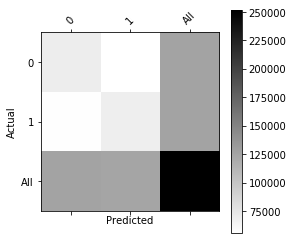

In [52]:
def plot_confusion_matrix(df_confusion, cmap=plt.cm.gray_r):
    plt.matshow(df_confusion, cmap=cmap)
    plt.colorbar()
    tick_marks = np.arange(len(df_confusion.columns))
    plt.xticks(tick_marks, df_confusion.columns, rotation=45)
    plt.yticks(tick_marks, df_confusion.index)
    plt.ylabel(df_confusion.index.name)
    plt.xlabel(df_confusion.columns.name)

plot_confusion_matrix(df_confusion)

Sarcasm is often difficult for humans to detect with certainty. It depends on tone, context, elements of humor and misdirection, and often lies behind words contrary to its intended meaning. It also often has layers of meaning with varying degrees of seriousness.

No wonder ML has historically had such a difficult time identifying the salient features of sarcasm is plain text. In a dataset of 50% sarcasm and 50% nonsarcasm, our classifier could have guessed that all were sarcasm and gotten an accuracy score of 50%. It faired slightly better with an accuracy of just under 67%.

We will look at other ML approaches, especially Deep Learning models, as we continue.